<center>
<h1>STAT 654: Statistical Computing with R and Python</h1>
<h2>Polynomial Regression</h2>
<strong>
Daniel Drennan<br>
Dr. Sharmistha Guha<br><br>
Department of Statistics<br>
Texas A&M University<br>
College Station, TX, USA<br><br>
Spring 2022<br>
</strong>
</center>

This is reproducing a Python example of the code shared by Professor Guha in `polynomials.R`.
There are small changes in the variable declarations
(namely, changing `x` to `sampled_x` and using `x` as a vector with more points for plotting).
Otherwise this notebook transfers the original code as closely as possible.

NB: This code requires loading the `plot` function from `src/plotting.py` or copying/pasting it into a cell
with function definitions. A longer explanation for how to do this is included in the `regression.ipynb` notebook.

In [46]:
import os, sys
from functools import reduce

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np
import pandas as pd
import scipy as sp
import scipy.stats

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures

sys.path.insert(0, os.path.abspath("../src"))
from plotting import plot

We are generating functional data according to the following relationship:

```r
n <- 30
e <- rnorm(n,mean=0,sd=1)
n30 <- seq(1:30)
x <- (n30 - 0.5)/30
y <- 11.8 + 28*x - 70*(x^2) + 50*(x^3) + e
```

So we have a polynomial of degree 3 with coefficients $(11.8, 28, -70, 50)$, i.e. 
$y = 11.8 + 28x -70x^2 + 50x^3$ is the hidden functional we want to estimate.
I'm going to make this easier to modify by defining a helper function `poly`, which allows
one to easily modify the degree of the 

In [39]:
# We are going to generate data, so set a random seed for reproducibility.
# This is a best practice, c.f. Rule 10 in Taschuk and Wilson (2017). PLOS Computational Biology.
# https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1005412
# This only needs to be done once, at the start of a program or notebook, to make all of the results
# deterministically repeatable.

# In NumPy, random.seed, random.get_state, and random.set_state are the standard functions for
# controlling data generation. Documentation below.
#  - seed:      https://numpy.org/devdocs/reference/random/generated/numpy.random.seed.html
#  - get_state: https://numpy.org/devdocs/reference/random/generated/numpy.random.get_state.html
#  - set_state: https://numpy.org/devdocs/reference/random/generated/numpy.random.set_state.html
np.random.seed(654)

def poly(x:np.ndarray, coef:tuple, deg:int=None)->np.ndarray:
    """Construct a polynomial with coefficients coef and degree deg."""
    if deg == None:
        # The natural definition of the degree of a polynomial indicates its highest
        # power term; e.g., a cubic polynomial has degree 3.
        # However, the coef tuple should contain the null (intercept) value as well.
        # As such, keep the degree as length(coef) - 1.
        deg = len(coef) - 1
    return np.dot(coef, [x ** p for p in range(deg+1)])

In [40]:
# Construct samples on the interval (0, 30) for model estimation
n = 30
sampled_x = np.arange(n) + 0.5
sampled_x /= n

# Construct a linear space for plotting lines
x = np.linspace(0, 1, 500)

coef = (11.8, 28, -70, 50)
y_hidden = poly(sampled_x, coef, 3)

errors = np.random.normal(0, 1, size = 30)
y =  y_hidden + errors

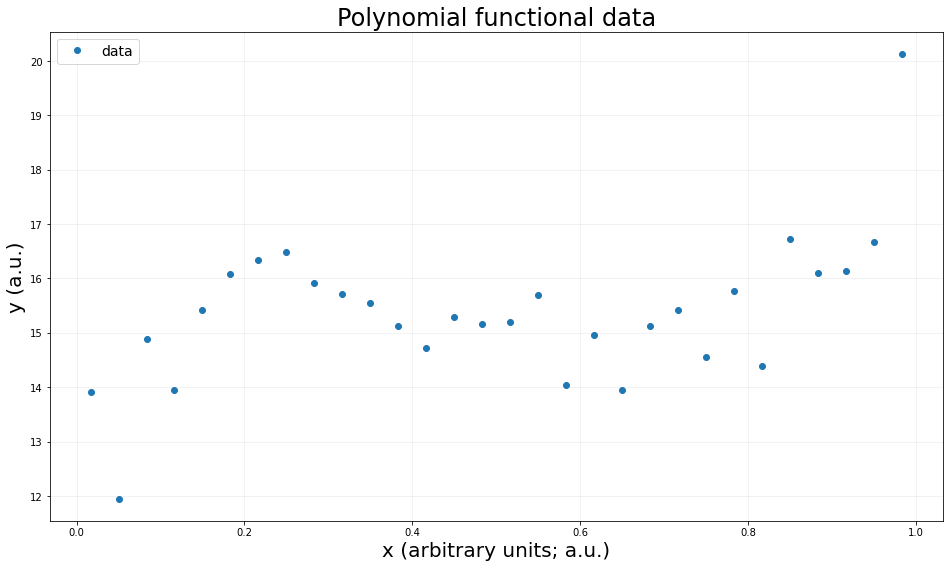

In [42]:
labels = {
    'title': 'Polynomial functional data',
    'x_label': 'x (arbitrary units; a.u.)', 
    'y_label': 'y (a.u.)'
}
plot(sampled_x, y, labels=labels, marker="o", linestyle="none", label="data")
plt.legend(fontsize=14)
plt.show()

In [57]:
# As far as I'm aware, statsmodels does not have a formula parser supporting polynomial
# regression fits. To overcome this, we will have to pass an explicitly constructed data matrix.
# scikit-learn offers the PolynomialFeatures class from its preprocessing module to assist:
X = PolynomialFeatures(degree=3).fit_transform(sampled_x.reshape(-1 ,1))

lm = sm.OLS(y, X).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.694
Model:                            OLS   Adj. R-squared:                  0.658
Method:                 Least Squares   F-statistic:                     19.63
Date:                Thu, 17 Feb 2022   Prob (F-statistic):           7.40e-07
Time:                        00:11:24   Log-Likelihood:                -33.363
No. Observations:                  30   AIC:                             74.73
Df Residuals:                      26   BIC:                             80.33
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.4565      0.581     21.447      0.000      11.263      13.650
x1            27.6435      5.036      5.489      0.000      17.291      37.996
x2           -68.5602     11.705     -5.857      0.000     -92.620     -44.501
x3            47.8159      7.695      6.214      0.000      31.998      63.634
==============================================================================
Omnibus:                        1.145   Durbin-Watson:                   2.464
Prob(Omnibus):                  0.564   Jarque-Bera (JB):                1.068
Skew:                          -0.303   Prob(JB):                        0.586
Kurtosis:                       2.302   Cond. No.                         126.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

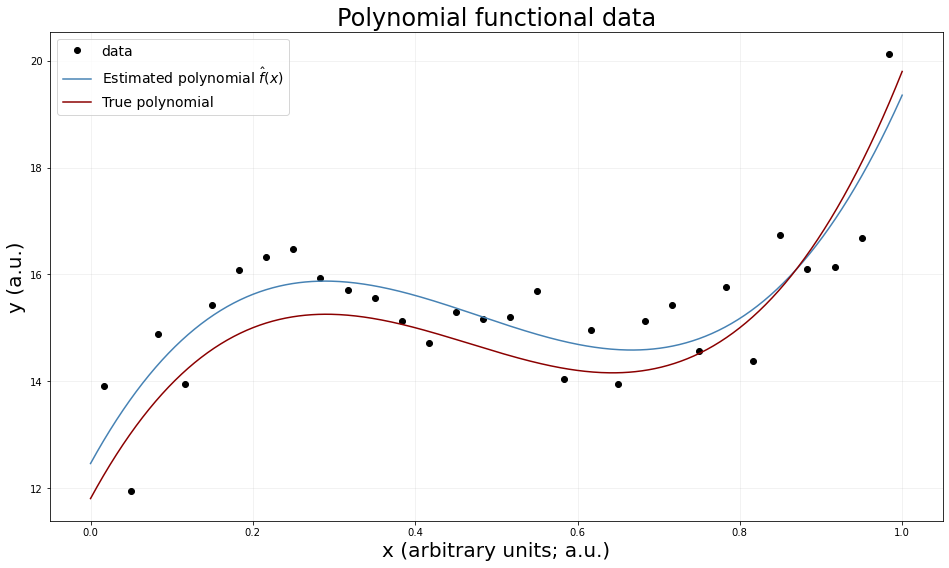

In [83]:
yhat = lm.predict()

yhat_line = poly(x, lm.params)

plot(sampled_x, y, labels=labels, marker="o", color="black", linestyle="none", label="data")
plt.plot(x, yhat_line, color="steelblue", label="Estimated polynomial $\hat{f}(x)$")
plt.plot(x, poly(x, coef), color="darkred", label="True polynomial")
plt.legend(fontsize=14)
plt.show()